# Policy iteration - Jack's car rental example

This notebook provides code to illustrate policy iteration. It is based off of Example 4.2 (page 81) of the book Reinforcement Learning by Sutton and Barto. 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import math
import seaborn as sn

We first define all of the parameters for the problem. 

In [2]:
n_cars = 20+1    # max number of cars at each location plus 1
lam_request1 = 3 # expected number of requests for cars per day at location 1, modelled by poisson distribution
lam_request2 = 4 # '' for location 2
lam_return1 = 3  # expected number of returns per day at location 1
lam_return2 = 2  # '' for location 2
gamma = 0.9      # gamma from value function update (value close to 0 means future returns ignored)
rental_reward = 10  # the reward per car rented
max_cars_moved = 5  # the maximum number of cars moved overnight
moving_cost = 2     # the cost of moving a car

In [3]:
def poisson_prob(lam, n):
    return lam**n/math.factorial(n)*np.exp(-lam)

In [4]:
def day_earnings(lam_request, cars_available):
    earnings = 0
    accumulated = poisson_prob(lam_request, 0) # will represent the probability that <= cars_available are requested
    for cars in range(1,cars_available+1):
        earnings += rental_reward*cars*poisson_prob(lam_request, cars)
        accumulated += poisson_prob(lam_request, cars)
    earnings += rental_reward*cars_available*(1-accumulated)
    return earnings

day_earnings(3, 7)

29.828059210679786

In [5]:
# computes the number of cars at each location if we choose to move m cars overnight
# positive m represents cars moved from location 1 to 2, negative m represents cars moved from 2 to 1

def transition(state, m):
    (loc1, loc2) = state
    new_loc1 = max(loc1 - m, 0) if m >= 0 else min(min(loc1 - m, loc1 + loc2), n_cars - 1)
    new_loc2 = min(loc2 + loc1 - new_loc1, n_cars - 1) if m >= 0 else max(loc2 + m, 0)
    cars_moved = min(m, loc1) if m >= 0 else -min(-m, loc2)
    return (new_loc1, new_loc2, cars_moved)

print(transition((2,5), -5))

(7, 0, -5)


In [6]:
# assume cars are returned at night

def transition_probability_per_loc(morning_num, night_num, lam_request, lam_return):
    prob = 0
    diff = morning_num - night_num
    if night_num != n_cars-1:
        for requests in range(max(0, diff), 4*lam_request):
            returns = min(-diff + requests, night_num)
            prob += poisson_prob(lam_return, returns)*poisson_prob(lam_request, requests)
    else:
        for requests in range(4*lam_request):
            for returns in range(requests-diff, 4*lam_return):
                prob += poisson_prob(lam_return, returns)*poisson_prob(lam_request, requests)
    return prob

In [7]:
def transition_probability(old_state, new_state, m):
    (morning_num1, morning_num2, _) = transition(old_state, m)
    (night_num1, night_num2) = new_state
    prob1 = transition_probability_per_loc(morning_num1, night_num1, lam_request1, lam_return1)
    prob2 = transition_probability_per_loc(morning_num2, night_num2, lam_request2, lam_return2)
    return prob1*prob2
    
transition_probability((0,5), (0,5), 0)

0.006384423552369645

In [8]:
def all_transition_probabilities(state, m):
    transition_probabilities = np.zeros((n_cars, n_cars))
    for i in range(n_cars):
        for j in range(n_cars):
            transition_probabilities[i,j] = transition_probability(state, (i,j), m)
    return transition_probabilities


def probabilities_truncate(transition_prob, cutoff):
    transition_prob[transition_prob < cutoff] = 0
    return transition_prob    

In [9]:
def reward(state, m):
    # action = m = number of cars to move from 1 to 2
    (loc1, loc2) = state
    (new_loc1, new_loc2, cars_moved) = transition(state, m)
    loc1_reward = day_earnings(lam_request1, new_loc1)
    loc2_reward = day_earnings(lam_request2, new_loc2)
    total_reward = -moving_cost*abs(cars_moved) + loc1_reward + loc2_reward
    return total_reward

In [10]:
truncation_cutoff = 10**-6

In [11]:
# synchronous update
def update_values(values, policy):
    new_values = np.zeros((n_cars,n_cars))
    for i in range(n_cars):
        for j in range(n_cars):
            m = policy[i,j]
            transition_probabilities = all_transition_probabilities((i,j), m)
            trunc_transition_prob = probabilities_truncate(transition_probabilities, truncation_cutoff)
            new_values[i,j] = reward((i, j), m) + gamma*np.sum(values*trunc_transition_prob)
    return new_values

In [12]:
def update_policy(values):
    policy = np.zeros((n_cars, n_cars), dtype=np.int8)
    for i in range(n_cars):
        for j in range(n_cars):
            best_reward = 0
            best_action = 0
            for m in range(-max_cars_moved, max_cars_moved+1):
                (new_i, new_j, cars_moved) = transition((i,j), m)
                transition_probabilities = all_transition_probabilities((i,j), m)
                trunc_transition_prob = probabilities_truncate(transition_probabilities, truncation_cutoff)
                _reward = reward((i, j), m) + gamma*np.sum(values*trunc_transition_prob)
                if _reward > best_reward:
                    best_reward = _reward
                    best_action = cars_moved
            policy[i,j] = best_action
    return policy

In [17]:
def policy_iteration(initial_values, initial_policy, policy_iters, value_iters, eps=None, stopping_point=50):
    values = initial_values
    policy = initial_policy
    for k in range(policy_iters):
        print("Starting policy iteration", k)
        if eps != None:
            value_diff = np.full((n_cars, n_cars), np.inf)
            stop = 0
            while (np.absolute(value_diff)>eps).any():
                print("Maximum value update {:.2f}".format(max(value_diff)))
                new_values = update_values(values, policy)
                value_diff = new_values - values
                values = new_values
                if stop > stopping_point:
                    break
                stop += 1
        else:
            for i in range(value_iters):
                values = update_values(values, policy)
        policy = update_policy(values)
    return (values, policy)

In [18]:
initial_policy = np.zeros((n_cars,n_cars), dtype=np.int8)

In [19]:
initial_values = np.zeros((n_cars,n_cars))

In [20]:
(values, policy) = policy_iteration(initial_values = initial_values, initial_policy = initial_policy, 
                                    policy_iters=3, value_iters=5)

Starting policy iteration 0
Starting policy iteration 1
Starting policy iteration 2


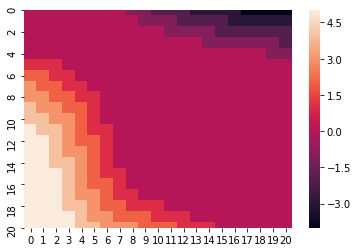

In [21]:
sn.heatmap(policy)